## Census Income Dataset
For this exercises we're using the Census Income dataset available from the <a href='http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a>.

The full dataset has 48,842 entries. For this exercise we have reduced the number of records, fields and field entries, and have removed entries with null values. The file <strong>income.csv</strong> has	30,000 entries

Each entry contains the following information about an individual:
* <strong>age</strong>: the age of an individual as an integer from 18 to 90 (continuous)
* <strong>sex</strong>: Male or Female (categorical)
* <strong>education</strong>: represents the highest level of education achieved by an individual (categorical)
* <strong>education_num</strong>: represents education as an integer from 3 to 16 (categorical)
<div><table style="display: inline-block">
<tr><td>3</td><td>5th-6th</td><td>8</td><td>12th</td><td>13</td><td>Bachelors</td></tr>
<tr><td>4</td><td>7th-8th</td><td>9</td><td>HS-grad</td><td>14</td><td>Masters</td></tr>
<tr><td>5</td><td>9th</td><td>10</td><td>Some-college</td><td>15</td><td>Prof-school</td></tr>
<tr><td>6</td><td>10th</td><td>11</td><td>Assoc-voc</td><td>16</td><td>Doctorate</td></tr>
<tr><td>7</td><td>11th</td><td>12</td><td>Assoc-acdm</td></tr>
</table></div>
* <strong>marital-status</strong>: marital status of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Married</td><td>Divorced</td><td>Married-spouse-absent</td></tr>
<tr><td>Separated</td><td>Widowed</td><td>Never-married</td></tr>
</table></div>
* <strong>workclass</strong>: a general term to represent the employment status of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Local-gov</td><td>Private</td></tr>
<tr><td>State-gov</td><td>Self-emp</td></tr>
<tr><td>Federal-gov</td></tr>
</table></div>
* <strong>occupation</strong>: the general type of occupation of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Adm-clerical</td><td>Handlers-cleaners</td><td>Protective-serv</td></tr>
<tr><td>Craft-repair</td><td>Machine-op-inspct</td><td>Sales</td></tr>
<tr><td>Exec-managerial</td><td>Other-service</td><td>Tech-support</td></tr>
<tr><td>Farming-fishing</td><td>Prof-specialty</td><td>Transport-moving</td></tr>
</table></div>
* <strong>hours-per-week</strong>: the hours an individual has reported to work per week as an integer from 20 to 90 (continuous)
* <strong>income</strong>: whether or not an individual makes more than \\$50,000 annually (label)
* <strong>label</strong>: income represented as an integer (0: <=\\$50K, 1: >\\$50K) (optional label)

## Imports
Run the cell below to load the libraries needed for this exercise and the Census Income dataset.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv('income.csv')

In [2]:
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [3]:
df['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

### 1. Separate continuous, categorical and label column names
Assign the variable names "cat_cols", "cont_cols" and "y_col" to the lists of names.

In [4]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [5]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')  # 5
print(f'cont_cols has {len(cont_cols)} columns') # 2
print(f'y_col     has {len(y_col)} column')      # 1

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


### 2. Convert categorical columns to category dtypes

In [5]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

### Shuffle the dataset

In [10]:
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,30,Male,Some-college,10,Married,Private,Transport-moving,80,>50K,1
1,69,Male,Masters,14,Married,Private,Prof-specialty,25,<=50K,0
2,49,Male,HS-grad,9,Married,Private,Transport-moving,48,>50K,1
3,43,Male,Some-college,10,Married,Private,Machine-op-inspct,40,<=50K,0
4,42,Male,HS-grad,9,Married,Private,Exec-managerial,50,>50K,1


### 3. Set the embedding sizes
Create a variable "cat_szs" to hold the number of categories in each variable.<br>
Then create a variable "emb_szs" to hold the list of (category size, embedding size) tuples.

In [11]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

### 4. Create an array of categorical values
Create a NumPy array called "cats" that contains a stack of each categorical column <tt>.cat.codes.values</tt><br>

In [12]:
sx = df['sex'].cat.codes.values
ed = df['education'].cat.codes.values
ms = df['marital-status'].cat.codes.values
wc = df['workclass'].cat.codes.values
oc = df['occupation'].cat.codes.values

cats = np.stack([sx,ed,ms,wc,oc], 1)

cats[:5]

array([[ 1, 13,  1,  2, 11],
       [ 1, 11,  1,  2,  7],
       [ 1, 10,  1,  2, 11],
       [ 1, 13,  1,  2,  5],
       [ 1, 10,  1,  2,  2]], dtype=int8)

### 5. Convert "cats" to a tensor
Convert the "cats" NumPy array to a tensor of dtype <tt>int64</tt>

In [13]:
cats = torch.tensor(cats, dtype=torch.int64)

### 6. Create an array of continuous values
Create a NumPy array called "conts" that contains a stack of each continuous column.<br>

In [14]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[30, 80],
       [69, 25],
       [49, 48],
       [43, 40],
       [42, 50]], dtype=int64)

### 7. Convert "conts" to a tensor
Convert the "conts" NumPy array to a tensor of dtype <tt>float32</tt>

In [15]:
conts = torch.tensor(conts, dtype=torch.float)
conts.dtype

torch.float32

### 8. Create a label tensor
Create a tensor called "y" from the values in the label column. Be sure to flatten the tensor so that it can be passed into the CE Loss function.

In [16]:
y = torch.tensor(df[y_col].values).flatten()

### 9. Create train and test sets from <tt>cats</tt>, <tt>conts</tt>, and <tt>y</tt>
We use the entire batch of 30,000 records, but a smaller batch size will save time during training.<br>
We used a test size of 5,000 records, but you can choose another fixed value or a percentage of the batch size.<br>
Make sure the test records remain separate from the training records, without overlap.<br>
To make coding slices easier, we recommend assigning batch and test sizes to simple variables like "b" and "t".

In [17]:
b = 30000 # suggested batch size
t = 5000  # suggested test size

cat_train = cats[:b-t]
cat_test  = cats[b-t:b]
con_train = conts[:b-t]
con_test  = conts[b-t:b]
y_train   = y[:b-t]
y_test    = y[b-t:b]

### Define the model class

In [18]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

### 10. Create a TabularModel instance
Create an instance called "model" with one hidden layer containing 50 neurons and a dropout layer p-value of 0.4

In [20]:
model = TabularModel(emb_szs, conts.shape[1], 2, [50], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

### 11. Define the loss and optimization functions
Create a loss function called "criterion" using CrossEntropyLoss<br>
Create an optimization function called "optimizer" using Adam, with a learning rate of 0.001

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model
Run the cell below to train the model through 300 epochs. <br>

In [22]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.65082830
epoch:  26  loss: 0.54084849
epoch:  51  loss: 0.47042167
epoch:  76  loss: 0.41546714
epoch: 101  loss: 0.37865609
epoch: 126  loss: 0.35645729
epoch: 151  loss: 0.34422594
epoch: 176  loss: 0.33623171
epoch: 201  loss: 0.32757205
epoch: 226  loss: 0.31838438
epoch: 251  loss: 0.31405076
epoch: 276  loss: 0.31084296
epoch: 300  loss: 0.30750263

Duration: 150 seconds


### 12. Plot the Cross Entropy Loss against epochs

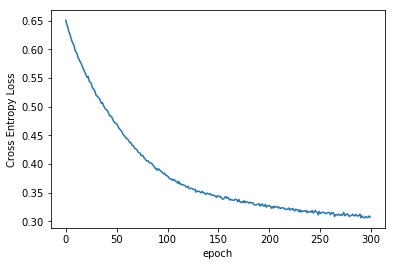

In [23]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

### 13. Evaluate the test set
With torch set to <tt>no_grad</tt>, pass <tt>cat_test</tt> and <tt>con_test</tt> through the trained model. Create a validation set called "y_val". Compare the output to <tt>y_test</tt> using the loss function defined above. 

In [24]:
# TO EVALUATE THE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.30892438


### 15. Calculate the overall percent accuracy
Using a for loop, compare the argmax values of the <tt>y_val</tt> validation set to the <tt>y_test</tt> set.

In [25]:
rows = len(y_test)
correct = 0

# print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')

for i in range(rows):
    # print(f'{str(y_val[i]):26} {y_val[i].argmax().item():^7}{y_test[i]:^7}')

    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4297 out of 5000 = 85.94% correct


### Feed new data through the trained model
Write a function that allows a user to input their own values, and generates a prediction.<br>

<br>There's no need to build a DataFrame. You can use inputs to populate column variables, convert them to embeddings with a context dictionary, and pass the embedded values directly into the tensor constructors:<br>
<pre>mar = input("What is the person's marital status? ")
mar_d = dict(Divorced=0, Married=1, Married-spouse-absent=2, Never-married=3, Separated=4, Widowed=5)
mar = mar_d[mar]
cats = torch.tensor([..., ..., mar, ..., ...], dtype=torch.int64).reshape(1,-1)</pre>
Make sure that names are put in alphabetical order before assigning numbers.

Also, be sure to run <tt>model.eval()</tt> before passing new date through. Good luck!

In [27]:
# DON'T WRITE HERE
def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    
test_data(model)

What is the person's age? (18-90)  30
What is the person's sex? (Male/Female) Female
What is the person's education level? (3-16) 12
What is the person's marital status? Never-married
What is the person's workclass? Private
What is the person's occupation? Other-service
How many hours/week are worked? (20-90)  37

The predicted label is 0
